# 0. Imports 

In [247]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# 1.0 Data Loading 

In [2]:
data_path = '../datasets/'
files = listdir(data_path)

full = files[1]
stats = files[2]

## 1.1 Full Matches 

In [3]:
df_full = pd.read_csv(data_path + full)

In [4]:
# indicando qual a temporada do campeonato

df_full.loc[:, 'data'] = pd.to_datetime(df_full.data, yearfirst=True)
df_full.insert(2, 'temporada', df_full.data.dt.year)
df_full.head()

,ID,rodada,temporada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [5]:
print(f'O número de linhas (exemplos) é {df_full.shape[0]} e de colunas (atributos) é {df_full.shape[1]}.')

O número de linhas (exemplos) é 7645 e de colunas (atributos) é 19.


In [6]:
df_full.groupby('temporada')['rodada'].max()

temporada
2003    46
2004    46
2005    42
2006    38
2007    38
2008    38
2009    38
2010    38
2011    38
2012    38
2013    38
2014    38
2015    38
2016    38
2017    38
2018    38
2019    38
2020    27
2021    38
Name: rodada, dtype: int64

<b> Constatações <b>
- Algumas temporadas tem mais ou menos jogos;
- Em 2005 foram apenas 42 rodadas, pois era outro formato de campeonato; 
- A temporada 2020 está incompleta, pois deveriam ser 38 rodadas.

## 1.2  Full Statistics

In [7]:
df_stats = pd.read_csv(data_path + stats)
df_stats.head()

,partida_id,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


In [8]:
print(f'O número de linhas (exemplos) é {df_stats.shape[0]} e de colunas (atributos) é {df_stats.shape[1]}.')

O número de linhas (exemplos) é 15290 e de colunas (atributos) é 13.


In [9]:
# renomeando a coluna para ficar compatível com df_full
df_stats = df_stats.rename(columns = {'partida_id': 'ID'})

# 2.0 Data Cleaning 

In [10]:
# uma copia para facilitar recuperar os dados
df_full2 = df_full.copy()
df_stats2 = df_stats.copy()

## 2.1 Full Matches

Como jogadores e técnicos mudam com frequência, só serão utilizados os dados dos campeonatos 2019, 2020 e 2021 nas análises.

In [11]:
df_full2 = df_full2[df_full2.temporada > 2018].reset_index(drop=True)

In [12]:
print('% of NaN')
df_full2.isna().sum()/df_full2.shape[0]

% of NaN


ID                    0.0
rodada                0.0
temporada             0.0
data                  0.0
hora                  0.0
dia                   0.0
mandante              0.0
visitante             0.0
formacao_mandante     0.0
formacao_visitante    0.0
tecnico_mandante      0.0
tecnico_visitante     0.0
vencedor              0.0
arena                 0.0
mandante_placar       0.0
visitante_placar      0.0
mandante_estado       0.0
visitante_estado      0.0
estado_vencedor       0.0
dtype: float64

In [13]:
# para garantir features com itens unicos

def lower_case_features(df):
    """
    Transforma todas as letras em minúsculas
    """
    for column in df.columns.tolist():
        if (df[column].dtypes == 'object'):
            df[column] = [x.lower() for x in df[column].values]
    return df
            
df_full2 = lower_case_features(df_full2)

In [14]:
# criar as classes da variavel alvo

def encode_target(row):
    """
    Tranforma os resultados com base no vencedor, seguindo:
    0 - empate
    1 - mandante
    2 - visitante
    """
    if row['mandante'] == row['vencedor']:
        return 1
    elif row['visitante'] == row['vencedor']:
        return 2
    else:
        return 0

df_full2['vencedor'] = df_full2.apply(encode_target, axis = 1)    

In [15]:
df_full2 = df_full2.reset_index(drop=True)

In [16]:
df_full2.head()

,ID,rodada,temporada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,6506,1,2019,2019-04-27,16:02,sabado,sao paulo,botafogo-rj,4-2-3-1,4-1-4-1,e. de souza barroca,e. de souza barroca,1,morumbi,2,0,sp,rj,sp
1,6507,1,2019,2019-04-27,19:00,sabado,atletico-mg,avai,4-2-3-1,4-1-4-1,e. machado souto,e. machado souto,1,estadio raimundo sampaio,2,1,mg,sc,mg
2,6508,1,2019,2019-04-27,19:01,sabado,chapecoense,internacional,4-2-3-1,4-3-3,o. hellmann,o. hellmann,1,arena conda,2,0,sc,rs,sc
3,6509,1,2019,2019-04-27,21:00,sabado,flamengo,cruzeiro,4-2-3-1,4-2-3-1,l. venker de menezes,l. venker de menezes,1,maracana,3,1,rj,mg,rj
4,6510,1,2019,2019-04-28,11:03,domingo,gremio,santos,4-2-3-1,3-4-1-2,j. sampaoli moya,j. sampaoli moya,2,arena do gremio,1,2,rs,sp,sp


## 2.2 Full Statistics

Os dados das estatísticas da partida não possuem a coluna de data, mas o ID servirá como filtro para fatiar o mesmo período.

In [17]:
df_full2.head()

,ID,rodada,temporada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,6506,1,2019,2019-04-27,16:02,sabado,sao paulo,botafogo-rj,4-2-3-1,4-1-4-1,e. de souza barroca,e. de souza barroca,1,morumbi,2,0,sp,rj,sp
1,6507,1,2019,2019-04-27,19:00,sabado,atletico-mg,avai,4-2-3-1,4-1-4-1,e. machado souto,e. machado souto,1,estadio raimundo sampaio,2,1,mg,sc,mg
2,6508,1,2019,2019-04-27,19:01,sabado,chapecoense,internacional,4-2-3-1,4-3-3,o. hellmann,o. hellmann,1,arena conda,2,0,sc,rs,sc
3,6509,1,2019,2019-04-27,21:00,sabado,flamengo,cruzeiro,4-2-3-1,4-2-3-1,l. venker de menezes,l. venker de menezes,1,maracana,3,1,rj,mg,rj
4,6510,1,2019,2019-04-28,11:03,domingo,gremio,santos,4-2-3-1,3-4-1-2,j. sampaoli moya,j. sampaoli moya,2,arena do gremio,1,2,rs,sp,sp


In [18]:
print('O primeiro ID das partidas desde 2019 é:', df_full2.loc[0,'ID'])

O primeiro ID das partidas desde 2019 é: 6506


In [19]:
# Entao servira como filtro
df_stats2 = df_stats2[df_stats2.ID >= df_full2.loc[0,'ID']]

In [20]:
print('% of NaN')
df_stats2.isna().sum()/df_stats2.shape[0]

% of NaN


ID                 0.0
rodada             0.0
clube              0.0
chutes             0.0
chutes_no_alvo     0.0
posse_de_bola      0.0
passes             0.0
precisao_passes    0.0
faltas             0.0
cartao_amarelo     0.0
cartao_vermelho    0.0
impedimentos       0.0
escanteios         0.0
dtype: float64

In [21]:
df_stats2 = df_stats2.reset_index(drop=True)

In [22]:
# alguns valores de posse_de_bola e precisao_passes sao object, possuem Nan e simbolo '%'
df_stats2['posse_de_bola'] = df_stats2['posse_de_bola'].apply(lambda x: np.nan if x == 'None' else x)
df_stats2['precisao_passes'] = df_stats2['precisao_passes'].apply(lambda x: np.nan if x == 'None' else x)

# retirando 
df_stats2 = df_stats2.dropna()

df_stats2['posse_de_bola'] = df_stats2['posse_de_bola'].apply(lambda x: int(x[0:2])/100)
df_stats2['precisao_passes'] = df_stats2['precisao_passes'].apply(lambda x: int(x[0:2])/100)

df_stats2 = lower_case_features(df_stats2)
df_stats2 = df_stats2.reset_index(drop=True)

In [23]:
df_stats2.head()

,ID,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,6506,1,sao paulo,7,4,0.28,269,0.75,23,0,0,2,3
1,6506,1,botafogo-rj,11,2,0.72,702,0.89,7,4,0,1,2
2,6507,1,atletico-mg,11,3,0.60,549,0.86,12,0,0,0,4
3,6507,1,avai,6,1,0.40,362,0.79,18,1,0,1,4
4,6508,1,chapecoense,12,7,0.43,392,0.77,15,1,0,0,3


# 3.0 Exploratory Data Analysis

A ideia aqui é tentar adquirir algum conhecimento das variáveis que possa ajudar a identificar as melhores features e modelos que possam ser utilizados posteriormente. Também são geradas algumas hipóteses com base nestas análises.

In [24]:
df_full3 = df_full2.copy()
df_stats3 = df_stats2.copy()

## 3.1 Winner by Home x Away

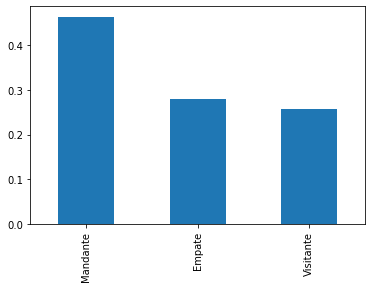

In [25]:
df_full3.vencedor.value_counts(normalize=True).plot(kind='bar');
plt.xticks(ticks=[0, 1, 2], labels=['Mandante', 'Empate', 'Visitante']);

<b> Constatações </b>
- A maioria dos jogos é vencida pelo mandante; 
- Os visitantes vencem na menor frequência

## 3.2 Winner by Day of the Week

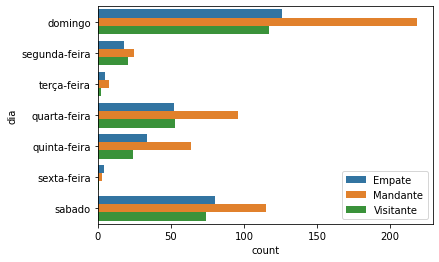

In [26]:
sns.countplot(y=df_full3.dia, hue=df_full3.vencedor, order=['domingo', 'segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sabado']);
plt.legend(['Empate', 'Mandante', 'Visitante']);

<b> Constatações </b>
- Visualmente não há diferença no efeito mandante x visitante em diferentes dias da semana;
- A única exceção é a segunda-feira, mas não foi feita análise da significância desta diferença;

## 3.3 Winner by State 

In [27]:
df_aux = df_full3[['temporada', 'mandante', 'mandante_estado']]
df_aux2 = pd.DataFrame(pd.DataFrame(df_aux.groupby(['temporada', 'mandante_estado']).value_counts()).drop(0, axis = 1).groupby(['temporada', 'mandante_estado']).value_counts(), columns=['counts'])
df_aux2 = df_aux2.reset_index()

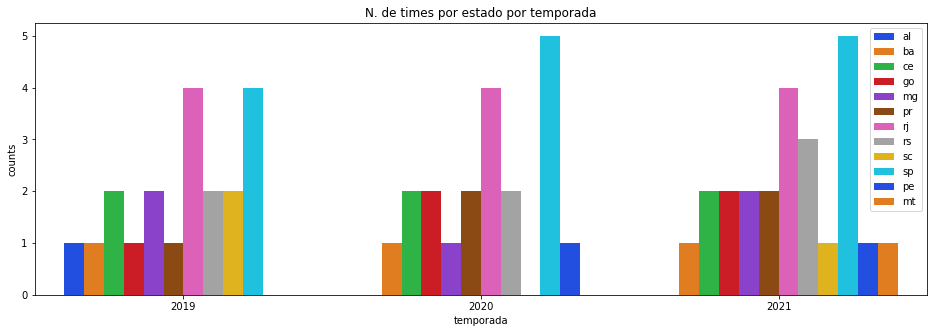

In [28]:
plt.figure(figsize=(16,5));
sns.barplot(x=df_aux2.temporada, y=df_aux2.counts, hue=df_aux2.mandante_estado, palette='bright');
plt.legend();
plt.title('N. de times por estado por temporada');

<b> Para avaliar os times que mais venceram por temporada, é mais coerente apresentar a relação entre n. de vitorias / n. de times, já que a distribuição da quantidade destes não é homogênea <b>

In [29]:
df_aux2 = df_aux2.set_index(['temporada', 'mandante_estado'])
df_aux2 = df_aux2.rename(columns={'counts': 'contagem_de_times'})

df_aux3 = pd.DataFrame(pd.DataFrame(df_full3[df_full2['estado_vencedor'] != '-'][['temporada', 'estado_vencedor']] \
                                    .value_counts(), columns=['contagem_vitoria']).groupby(['temporada', 'estado_vencedor']) \
                                    .value_counts()).drop(0, axis = 1) \
                                    .reset_index(['contagem_vitoria'])

df_aux4 = pd.concat([df_aux2, df_aux3], axis = 1)
df_aux4.loc[:, 'vitorias_por_times'] = df_aux3.contagem_vitoria / df_aux4.contagem_de_times
df_aux4.head()

contagem_de_times  contagem_vitoria  vitorias_por_times
temporada                                                            
2019      al                  1                 8                 8.0
          ba                  1                12                12.0
          ce                  2                25                12.5
          go                  1                15                15.0
          mg                  2                20                10.0

<b> Constatações </b>
- São Paulo e Rio de Janeiro são os clubes com maior quantidades de times na série A;
- Rio Grande do Sul em 2021 aparece com 3 clubes;
- No geral, a maioria dos estados tem entre 1 e 2 times na série A;

### 3.3.1 Winner by state x time

In [30]:
df_aux4 = df_aux4.reset_index()
df_aux4 = df_aux4.rename(columns={'level_1': 'time'})
df_aux4.head()

,temporada,time,contagem_de_times,contagem_vitoria,vitorias_por_times
0,2019,al,1,8,8.0
1,2019,ba,1,12,12.0
2,2019,ce,2,25,12.5
3,2019,go,1,15,15.0
4,2019,mg,2,20,10.0


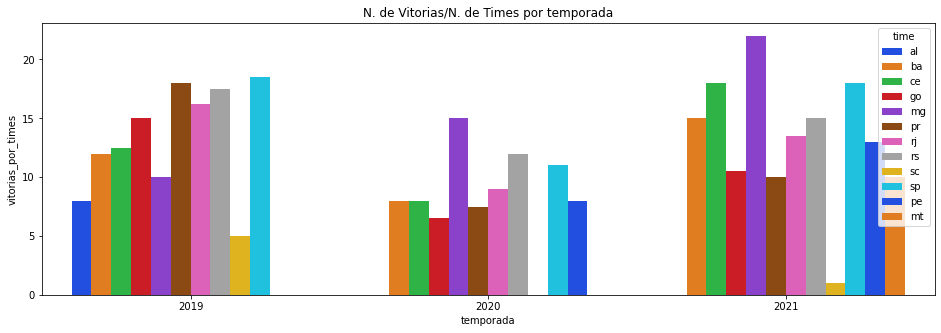

In [31]:
plt.figure(figsize=(16, 5));
sns.barplot(x=df_aux4['temporada'], y=df_aux4['vitorias_por_times'], hue=df_aux4['time'], palette='bright');
plt.title('N. de Vitorias/N. de Times por temporada');

<b> Constatações </b>
- MG aparece como o estado mais vitorioso nos últimos 2 anos da série;
- SP mesmo com a racionalização dos valores, ainda é um dos estados mais vitoriosos;


### 3.3.2 Most Winning States 

In [32]:
df_aux5 = df_aux4.groupby('time').sum().drop('vitorias_por_times', axis = 1)
df_aux5.loc[:, 'vitorias_por_times'] = df_aux5.contagem_vitoria / df_aux5.contagem_de_times
df_aux5 = df_aux5.reset_index().drop(['temporada'], axis = 1)

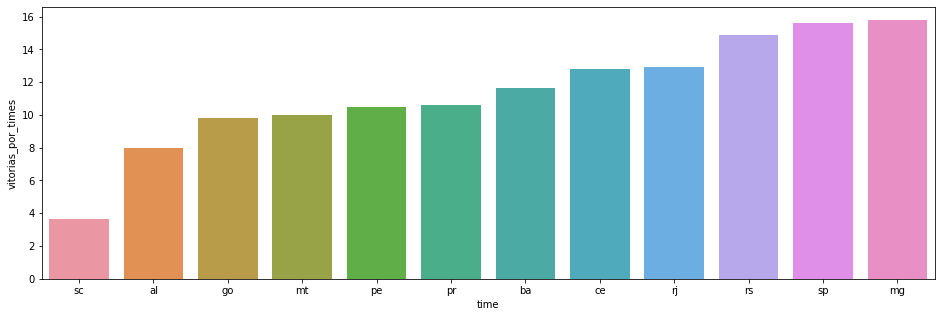

In [33]:
plt.figure(figsize=(16,5));
sns.barplot(x = df_aux5.sort_values('vitorias_por_times').time, y = df_aux5.sort_values('vitorias_por_times').vitorias_por_times, );

<b> Constatações </b>
- No agregado geral, MG mantém a liderança, seguido por SP;
- Já RJ, ocupa a 4a posição, mesmo tendo quase sempre mais times no campeonato.

## 3.4 Goals Distribution 

### 3.4.1 Overview 

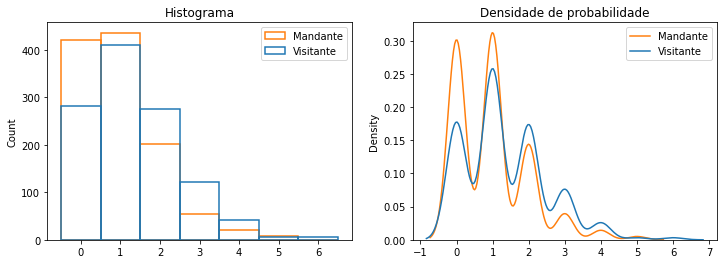

In [34]:
plt.figure(figsize=(12,4));
plt.subplot(1,2,1);
sns.histplot(data=df_full3[['mandante_placar', 'visitante_placar']], discrete=True, binwidth=0.5, fill=False );
plt.legend(['Mandante', 'Visitante']);
plt.title('Histograma');
plt.subplot(1,2,2);
sns.kdeplot(data=df_full3[['mandante_placar', 'visitante_placar']]);
plt.legend(['Mandante', 'Visitante']);
plt.title('Densidade de probabilidade');

<b> Constatações </b>
- 1 Gol por partida é bastante frequente, sendo até mais comum que partidas sem gols;
- Os visitantes fazem mais vezes 2 gols ou mais gols que os mandantes;

### 3.4.2  Goals by round over the time

In [35]:
df_full3.loc[:, 'total_de_gols'] = df_full3['mandante_placar'] + df_full3['visitante_placar']
df_aux = pd.DataFrame(df_full3.groupby(['temporada', 'rodada']).sum()['total_de_gols']).reset_index()

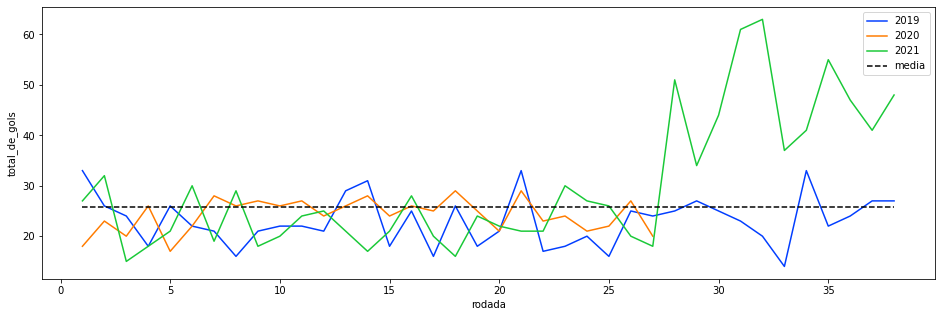

In [36]:
plt.figure(figsize=(16,5));
sns.lineplot(y=df_aux.total_de_gols, x=df_aux.rodada, hue=df_aux.temporada, palette='bright');
plt.hlines(df_aux.total_de_gols.mean(), xmin = 1, xmax=38, color='black', label='media', linestyle='dashed');
plt.legend();

<b> Constatações </b>
- Com exceção das últimas rodadas do campeonato de 2021, a rodada do campeonato não aparenta influenciar o número de gols;

## 3.5 Kicks 

### 3.5.1 Overview 

<b>Top 10 maiores chutadores<b>

In [37]:
print('Top 10 em chutes por partida')
df_stats3.groupby('clube').mean().sort_values('chutes', ascending=False).head(10)['chutes']

Top 10 em chutes por partida


clube
atletico-mg    15.572727
flamengo       15.380531
america-mg     15.210526
palmeiras      14.473214
bragantino     14.381579
gremio         14.071429
sao paulo      13.455357
cruzeiro       13.400000
santos         13.070175
bahia          13.000000
Name: chutes, dtype: float64

<b>Top 10 chutadores mais precisos<b>

In [38]:
print('Top 10 em chutes no alvo por partida')
df_stats3.groupby('clube').mean().sort_values('chutes_no_alvo', ascending=False).head(10)['chutes_no_alvo']

Top 10 em chutes no alvo por partida


clube
flamengo         5.840708
atletico-mg      5.227273
palmeiras        4.883929
gremio           4.696429
bragantino       4.618421
sao paulo        4.571429
santos           4.552632
internacional    4.508772
america-mg       4.394737
bahia            4.342105
Name: chutes_no_alvo, dtype: float64

<b> Constatações </b>
- Flamengo e Atlético-MG são os times que mais chutaram ao gol;
- Flamengo e Atlético-MG são os times que tem maior precisão no chute.

### 3.5.2 Kicks by all teams over the time

In [39]:
# como df_stats3 nao tem a data, sera inlcuida
df_stats3 = pd.merge(df_stats3, df_full3[['ID','data']], on='ID')

In [40]:
# criando uma feature para temporada e mudando a posicao dela e da data
df_stats3.insert(2, 'temporada', df_stats3.data.dt.year)
df_aux = df_stats3[['data']]
df_stats3 = df_stats3.drop('data', axis = 1)
df_stats3.insert(3, 'data', df_aux)

In [41]:
df_aux = pd.DataFrame(df_stats3.groupby(['temporada', 'rodada']).mean()['chutes']).reset_index()

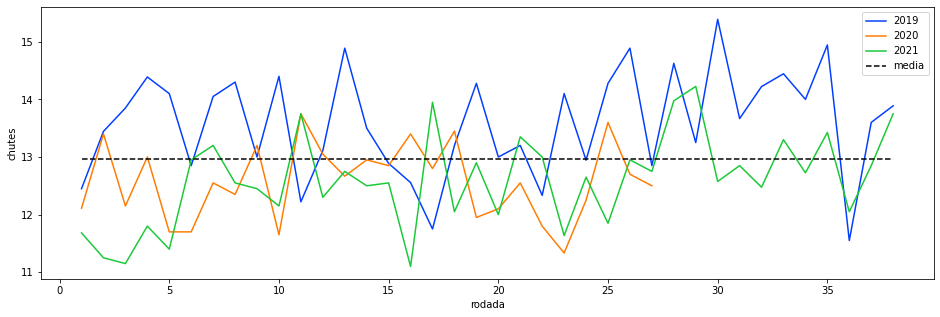

In [42]:
plt.figure(figsize=(16,5));
sns.lineplot(y=df_aux.chutes, x=df_aux.rodada, hue=df_aux.temporada, palette='bright');
plt.hlines(df_aux.chutes.mean(), xmin = 1, xmax=38, color='black', label='media', linestyle='dashed');
plt.legend();

In [43]:
print('Estatísticas dos chutes por temporada')
df_aux.groupby('temporada')['chutes'].describe()

Estatísticas dos chutes por temporada


,count,mean,std,min,25%,50%,75%,max
temporada,,,,,,,,
2019,38.0,13.589547,0.918254,11.550000,12.958333,13.633333,14.277778,15.388889
2020,27.0,12.574486,0.660720,11.333333,12.105556,12.550000,13.025000,13.750000
2021,38.0,12.600478,0.799922,11.100000,12.050000,12.612500,12.987500,14.225000


<b> Constatações <b>
- Visualmente, o ano de 2019 teve mais chutes ao gol em geral;
- 2019 vem maior variabilidade no número de chutes por dada;
- As estatísticas estão bem próximas ao longo destes anos, mas não foi analisada significância estatística.

## 3.6 Ball possession 

### 3.6.1 Overview 

<b> Top 10 clubes em posse de bola <b>

In [44]:
print('Top 10 em média da posse de bola por partida')
df_stats3.groupby('clube').mean().sort_values('posse_de_bola', ascending=False).head(10)['posse_de_bola']

Top 10 em média da posse de bola por partida


clube
flamengo         0.599115
sao paulo        0.559107
atletico-mg      0.559000
gremio           0.540804
santos           0.538421
cruzeiro         0.526571
athletico-pr     0.524255
corinthians      0.522035
fluminense       0.520000
internacional    0.512982
Name: posse_de_bola, dtype: float64

### 3.6.2 Ball possession over the time

In [45]:
df_aux = df_stats3.groupby(['temporada', 'clube']).mean()[['posse_de_bola']].reset_index();

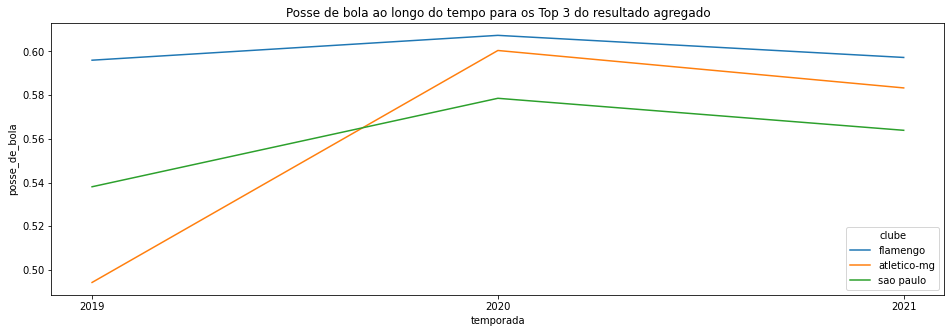

In [46]:
df_aux2 = pd.concat([df_aux[df_aux['clube'] == 'flamengo'], df_aux[df_aux['clube'] == 'atletico-mg'], df_aux[df_aux['clube'] == 'sao paulo']], axis=0)
plt.figure(figsize=(16,5));
sns.lineplot(x=df_aux2.temporada, y=df_aux2.posse_de_bola, hue=df_aux2.clube);
plt.xticks([2019, 2020, 2021])
plt.title('Posse de bola ao longo do tempo para os Top 3 do resultado agregado');

<b> Constatações </b>
- Flamengo é o time que tem maior posse de bola;
- Atlético-MG e São Paulo estão praticamente empatados na segunda colocação;
- Flamengo manteve praticamente a mesma posse de bola ao longo do tempo;
- A posse de bola do Atlético-MG teve um aumento visualmente significativo.

## 3.7 Faults 

In [47]:
print('Top 10 na média do n. de faltas por jogo')
df_stats3.groupby('clube').mean().sort_values('faltas', ascending=False).head(10)['faltas']

Top 10 na média do n. de faltas por jogo


clube
sao paulo        16.428571
internacional    16.307018
athletico-pr     16.138298
goias            15.756757
palmeiras        15.714286
coritiba         15.684211
flamengo         15.672566
vasco            15.662162
bragantino       15.631579
csa              15.314286
Name: faltas, dtype: float64

## 3.7 Yellow and Red Cards 

In [48]:
print('Top 10 na média do n. de cartões amarelos por jogo')
df_stats3.groupby('clube').mean().sort_values('cartao_amarelo', ascending=False).head(10)['cartao_amarelo']

Top 10 na média do n. de cartões amarelos por jogo


clube
goias            2.540541
internacional    2.526316
vasco            2.391892
santos           2.368421
csa              2.342857
sao paulo        2.330357
sport            2.328947
juventude        2.315789
flamengo         2.230088
ceara            2.228070
Name: cartao_amarelo, dtype: float64

In [49]:
print('Top 10 na média do n. de cartões vermelhos por jogo')
df_stats3.groupby('clube').mean().sort_values('cartao_vermelho', ascending=False).head(10)['cartao_vermelho']

Top 10 na média do n. de cartões vermelhos por jogo


clube
avai             0.277778
coritiba         0.210526
internacional    0.201754
fortaleza        0.159292
cuiaba           0.157895
palmeiras        0.151786
bahia            0.149123
goias            0.148649
gremio           0.142857
cruzeiro         0.142857
Name: cartao_vermelho, dtype: float64

# 4.0 Hypothesis 

Algumas hipóteses podem ajudar a determinar as melhores features e insights para construção dos modelos, tais como:
<ol>
    <li>O time que mais chuta a gol é o que faz mais gols;</li>
    <li>O time que mais chuta a gol é o mais vencedor;</li>
    <li>O time que mais tem posse de bola é o mais vencedor.</li>
</ol>

In [358]:
df_full4 = df_full3.copy()
df_stats4 = df_stats3.copy()

In [495]:
len(df_stats4.ID.unique())

1116

In [496]:
len(df_full4.ID.unique())

1140

In [506]:
# cria um dataframe com as estatisticas de cada partida
def add_attributes(df_stats, df_full):
    """
    This function merge some attributes from two differente df, considering home x away teams
    """
   
    columns = df_stats.columns.to_list()[5:-1]
           
    for row in range(len(df_full)):
        for column in columns:
            if (df_stats[['ID']] == df_full.loc[row, 'ID']) & (df_stats[['clube']] == df_full.loc[row, 'mandante']):
                df_full.loc[row, 'mandante_' + column] = df_stats[(df_stats['ID'] == df_full.loc[row, 'ID']) & (df_stats['clube'] == df_full.loc[row, 'mandante'])][column].values[0]
            #else:
            #    df_full.loc[row, 'mandante_' + column] = np.nan
                
            if (df_stats[['ID']] == df_full.loc[row, 'ID']) & (df_stats[['clube']] == df_full.loc[row, 'visitante']):       
                df_full.loc[row, 'visitante_' + column] = df_stats[(df_stats['ID'] == df_full.loc[row, 'ID']) & (df_stats['clube'] == df_full.loc[row, 'visitante'])][column].values[0]
            #else:
            #    df_full.loc[row, 'visitante_' + column] = np.nan
                
    #df_full_stats_recent = df_full_stats_recent.drop(['mandante_clube', 'visitante_clube'], axis = 1)

    return df_full

In [ ]:
df4.

In [507]:
df4 = add_attributes(df_stats4, df_full4)b

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## 4.1 O time que mais chuta a gol é o que mais faz gols 

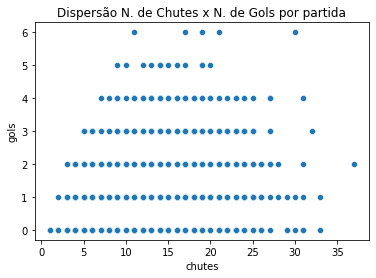

In [366]:
df_aux41 = pd.concat([df4[['mandante', 'mandante_chutes', 'mandante_placar']] \
                      .rename(columns={'mandante': 'clube', 'mandante_chutes': 'chutes', 'mandante_placar': 'gols'}),\
                      df4[['visitante', 'visitante_chutes', 'visitante_placar']] \
                      .rename(columns={'visitante': 'clube', 'visitante_chutes': 'chutes', 'visitante_placar': 'gols'})], axis=0)

sns.scatterplot(x=df_aux41.chutes, y=df_aux41.gols);
plt.title('Dispersão N. de Chutes x N. de Gols por partida');

In [367]:
df_aux41.corr()

,chutes,gols
chutes,1.00000,0.20163
gols,0.20163,1.00000


In [368]:
top_kicks_mean = df_aux41.groupby('clube').mean().sort_values('chutes', ascending=False)
top_kicks_sum = df_aux41.groupby('clube').sum().sort_values('gols', ascending=False)

In [369]:
print('Correlação entre as Médias')
top_kicks_mean.corr()

Correlação entre as Médias


,chutes,gols
chutes,1.000000,0.726253
gols,0.726253,1.000000


In [370]:
print('Correlação entre as somas')
top_kicks_sum.corr()

Correlação entre as somas


,chutes,gols
chutes,1.000000,0.968087
gols,0.968087,1.000000


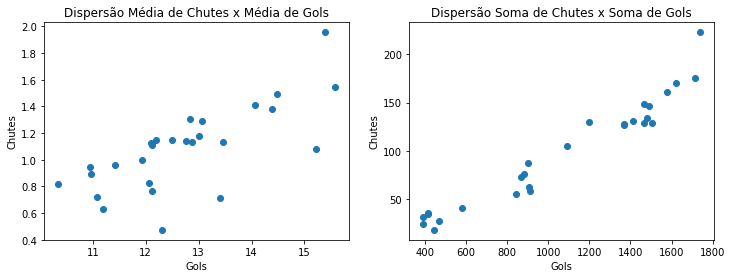

In [371]:
plt.figure(figsize=(12,4));

plt.subplot(1,2,1);
plt.scatter(x=top_kicks_mean.chutes, y=top_kicks_mean.gols);
plt.ylabel('Chutes');
plt.xlabel('Gols');
plt.title('Dispersão Média de Chutes x Média de Gols');


plt.subplot(1,2,2);
plt.scatter(x=top_kicks_sum.chutes, y=top_kicks_sum.gols);
plt.ylabel('Chutes');
plt.xlabel('Gols');
plt.title('Dispersão Soma de Chutes x Soma de Gols');

<b> Constatações </b>
- Numericamente, dadas as características do futebol em ser um jogo de baixa pontuação, não há correlação forte entre o número de chutes e o número de gols, quando os números são avaliados por partida.
- Entretanto, ao comparar os valores agregados pela média ou pela soma, nota-se que há forte correlação entre as duas variáveis.

<b> Conclusão: </b> parcialmente confirmada
- As evidências apontam que os times que mais chutam são os que possuem maior quantidade de gols marcados;
- Apesar de ser fraca a correlação por partida, este fator é decisivo em longo prazo (média e acumulado).

## 4.2 O time que é mais chuta é o mais vencedor

In [372]:
def win(row):  
    """
    Cria uma variavel auxiliar para contar as vitorias
    """
    if (row.index == 'mandante').any():
        if row['vencedor'] == 1:
            return 1
        else:
            return 0
        
    elif (row.index == 'visitante').any():
        if row['vencedor'] == 2:
            return 1
        else:
            return 0
    
    
df_aux42_mandante = df4[['temporada', 'mandante', 'vencedor']]
df_aux42_mandante.loc[:,'venceu'] = df_aux42_mandante.apply(win, axis = 1)

df_aux42_visitante = df4[['temporada', 'visitante', 'vencedor']]
df_aux42_visitante.loc[:,'venceu'] = df_aux42_visitante.apply(win, axis = 1)

df_aux42_visitante = df_aux42_visitante.rename(columns={'visitante': 'clube'})
df_aux42_mandante = df_aux42_mandante.rename(columns={'mandante': 'clube'})

df_aux42 = pd.concat([df_aux42_mandante, df_aux42_visitante], axis=0).drop('vencedor', axis = 1)
df_aux42 = df_aux42.reset_index(drop=True)

In [373]:
df_aux421 = pd.DataFrame(df_aux42.groupby(['temporada', 'clube']).value_counts()).reset_index()
df_aux421 = df_aux421[df_aux421['venceu'] == 1].rename(columns={0: 'n_vitorias'}).drop('venceu', axis = 1)

In [374]:
df_aux421 = df_aux421.groupby(['clube']).sum().drop('temporada', axis = 1)

In [375]:
df_aux_422 = pd.concat([df_aux421, top_kicks_mean.rename(columns={'chutes': 'chutes_mean'})[['chutes_mean']], top_kicks_sum.rename(columns={'chutes': 'chutes_sum'})[['chutes_sum']]], axis = 1)
df_aux_422.head()

,n_vitorias,chutes_mean,chutes_sum
clube,,,
america-mg,13,15.210526,578.0
athletico-pr,46,12.755319,1199.0
atletico-go,25,11.421053,868.0
atletico-mg,59,15.572727,1713.0
avai,3,12.305556,443.0


In [376]:
df_aux_422.corr()

,n_vitorias,chutes_mean,chutes_sum
n_vitorias,1.000000,0.604687,0.94251
chutes_mean,0.604687,1.000000,0.60275
chutes_sum,0.942510,0.602750,1.00000


<b> Conclusão: </b> confirmada.
- A variável de chute médio por partida tem uma correlação moderada-forte com o número de vitórias;
- A variável da soma de chutes por time tem uma correlação forte com o número de vitórias

## 4.3 O time que tem maior posse de bola é o mais vencedor

Como o número de vitórias está relacionado com o número de partidas, uma coluna indicando quantas foram jogadas ao longo das temporadas será criada. E, para retirar o efeito da escala, será obtida a razão do número de vitórias pelo número de jogos.

In [377]:
df_aux43 = pd.concat([df_aux421, df_stats2.groupby('clube').mean()[['posse_de_bola']], df_stats2.groupby(['clube']).count()[['rodada']]], axis = 1)
df_aux43 = df_aux43.rename(columns={'rodada': 'n_de_jogos'})
df_aux43.loc[:, 'vitorias_por_jogos'] = df_aux43.n_vitorias / df_aux43.n_de_jogos
df_aux43.sort_values('vitorias_por_jogos', ascending=False).head(10)

,n_vitorias,posse_de_bola,n_de_jogos,vitorias_por_jogos
clube,,,,
flamengo,70,0.599115,113,0.619469
atletico-mg,59,0.559000,110,0.536364
palmeiras,56,0.506071,112,0.500000
athletico-pr,46,0.524255,94,0.489362
santos,48,0.538421,114,0.421053
internacional,48,0.512982,114,0.421053
sao paulo,46,0.559107,112,0.410714
gremio,45,0.540804,112,0.401786
fluminense,45,0.520000,113,0.398230


In [378]:
df_aux43.drop(['n_de_jogos', 'n_vitorias'], axis = 1).corr()

,posse_de_bola,vitorias_por_jogos
posse_de_bola,1.00000,0.72138
vitorias_por_jogos,0.72138,1.00000


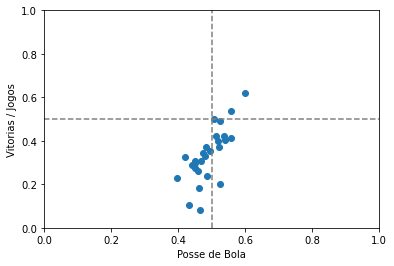

In [379]:
plt.scatter(df_aux43.posse_de_bola, df_aux43.vitorias_por_jogos);
plt.hlines(0.5, xmin=0, xmax=1, color='gray', linestyles='dashed')
plt.vlines(0.5, ymin=0, ymax=1, color='gray', linestyles='dashed')
plt.xlabel('Posse de Bola')
plt.ylabel('Vitorias / Jogos');
plt.xlim([0, 1]);
plt.ylim([0, 1]);

<b> Constatações: </b>
- Existe uma moderada-forte correlação entre posse de bola e o número de vitórias médio.
- Nota-se também que a proporção de posse de bola entre os times é de [40%, 60%];

<b> Conclusões: </b> confirmada.
- A posse de bola é determinante no resultado dos jogos.

#  5.0 Feature Engineering

In [478]:
df4.isna().sum()[df4.isna().sum() > 0]

mandante_chutes              24
visitante_chutes             24
mandante_chutes_no_alvo      24
visitante_chutes_no_alvo     24
mandante_posse_de_bola       24
visitante_posse_de_bola      24
mandante_passes              24
visitante_passes             24
mandante_precisao_passes     24
visitante_precisao_passes    24
mandante_faltas              24
visitante_faltas             24
mandante_cartao_amarelo      24
visitante_cartao_amarelo     24
mandante_cartao_vermelho     24
visitante_cartao_vermelho    24
mandante_impedimentos        24
visitante_impedimentos       24
dtype: int64

In [436]:
df5 = df4.copy()

Baseado no artigo referenciado abaixo, as seguintes features serão criadas:
- Número de vitórias na temporada;
- Número de derrotas do time na temporada;
- Número de empates do time na temporada;
- Número de vitórias do time em casa (%);
- Número de vitórias do time fora de casa (%);
- Número de empates do time em casa (%);
- Número de empates do time fora de casa (%);
- Número de derrotas do time em casa (%);
- Número de derrotas do time fora de casa (%);
- Sequência de vitórias em casa do time mandante;
- Sequência de vitórias em casa do time visitante;
- Sequência sem vitórias fora de casa do time mandante;
- Sequência sem vitórias fora de casa do time visitante;
- O time jogou na última temporada;
- Dias desde o último jogo;
- Gols marcados essa temporada jogando em casa;
- Gols marcados essa temporada jogando fora de casa;
- Gols sofridos essa temporada jogando em casa;
- Gols sofridos essa temporada jogando fora de casa;
- Número de vitórias do mandante contra o adversário;
- Número de vitórias do visitante contra o adversário.

## 5.1 Wins, loss and draw games 

In [437]:
pd.options.mode.chained_assignment = None

temporadas = df5['temporada'].value_counts().index.sort_values().values

df5['mandante_vitorias'] = df5['mandante']
df5['visitante_vitorias'] = df5['mandante']

df5['mandante_derrotas'] = df5['mandante']
df5['visitante_derrotas'] = df5['mandante']

df5['mandante_empates'] = df5['mandante']
df5['visitante_empates'] = df5['mandante']

for temporada in temporadas:
    dft = df5[df5['temporada'] == temporada]
    
    for index, row in dft.iterrows():
        df_home = dft[(dft['rodada'] < row['rodada']) & (dft['mandante'] == row['mandante'])]
        c1_wins = 0
        c1_loss = 0
        c1_draw = 0
        for index2, row2 in df_home.iterrows():
            if row2['vencedor'] == 0:
                c1_draw+=1
            elif row2['vencedor'] == 1:
                c1_wins+=1
            elif row2['vencedor'] == 2:
                c1_loss+=1

        df_away = dft[(dft['rodada'] < row['rodada']) & (dft['visitante'] == row['mandante'])]
        for index2, row2 in df_away.iterrows():
            if row2['vencedor'] == 1:
                c1_loss+=1                
            elif row2['vencedor'] == 0:
                c1_draw+=1
            elif row2['vencedor'] == 2:
                c1_wins+=1


        df_home = dft[(dft['rodada'] < row['rodada']) & (dft['mandante'] == row['visitante'])]
        c2_wins = 0
        c2_loss = 0
        c2_draw = 0
        for index2, row2 in df_home.iterrows():
            if row2['vencedor'] == 0:
                c2_draw+=1
            elif row2['vencedor'] == 1:
                c2_wins+=1                
            elif row2['vencedor'] == 2:
                c2_loss+=1

        df_away = dft[(dft['rodada'] < row['rodada']) & (dft['visitante'] == row['visitante'])]
        for index2, row2 in df_away.iterrows():
            if row2['vencedor'] == 1:
                c2_loss+=1                
            elif row2['vencedor'] == 0:
                c2_draw+=1
            elif row2['vencedor'] == 2:
                c2_wins+=1
                


        df5.at[index, 'mandante_vitorias'] = c1_wins
        df5.at[index, 'visitante_vitorias'] = c2_wins
        
        df5.at[index, 'mandante_derrotas'] = c1_loss
        df5.at[index, 'visitante_derrotas'] = c2_loss
        
        df5.at[index, 'mandante_empates'] = c1_draw
        df5.at[index, 'visitante_empates'] = c2_draw

In [438]:
df5.head()

,ID,rodada,temporada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,...,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_vitorias,visitante_vitorias,mandante_derrotas,visitante_derrotas,mandante_empates,visitante_empates
0,6506,1,2019,2019-04-27,16:02,sabado,sao paulo,botafogo-rj,4-2-3-1,4-1-4-1,...,0.0,0.0,2.0,1.0,0,0,0,0,0,0
1,6507,1,2019,2019-04-27,19:00,sabado,atletico-mg,avai,4-2-3-1,4-1-4-1,...,0.0,0.0,0.0,1.0,0,0,0,0,0,0
2,6508,1,2019,2019-04-27,19:01,sabado,chapecoense,internacional,4-2-3-1,4-3-3,...,0.0,0.0,0.0,2.0,0,0,0,0,0,0
3,6509,1,2019,2019-04-27,21:00,sabado,flamengo,cruzeiro,4-2-3-1,4-2-3-1,...,0.0,1.0,0.0,1.0,0,0,0,0,0,0
4,6510,1,2019,2019-04-28,11:03,domingo,gremio,santos,4-2-3-1,3-4-1-2,...,0.0,1.0,2.0,1.0,0,0,0,0,0,0


## 5.2 Wins, loss and draw games as home or away team

In [439]:
def find_wins_home(ser):
    wins = [0]
    
    [wins.append(wins[-1]+1) if win==0 else wins.append(wins[-1]) for win in ser.values]
    
    return wins[0:-1]

def find_wins_away(ser):
    wins = [0]
    
    [wins.append(wins[-1]+1) if win==1 else wins.append(wins[-1]) for win in ser.values]
    
    return wins[0:-1]

def find_draws(ser):
    wins = [0]
    
    [wins.append(wins[-1]+1) if win==2 else wins.append(wins[-1]) for win in ser.values]
    
    return wins[0:-1]

df5['vitorias_como_mandante'] = df5.groupby(['temporada', 'mandante'])['vencedor'].transform(lambda x: find_wins_home(x))
df5['derrotas_como_mandante'] = df5.groupby(['temporada', 'mandante'])['vencedor'].transform(lambda x: find_wins_away(x))
df5['vitorias_como_visitante'] = df5.groupby(['temporada', 'visitante'])['vencedor'].transform(lambda x: find_wins_away(x))
df5['derrotas_como_visitante'] = df5.groupby(['temporada', 'visitante'])['vencedor'].transform(lambda x: find_wins_home(x))
df5['empates_como_mandante'] = df5.groupby(['temporada', 'mandante'])['vencedor'].transform(lambda x: find_draws(x)) 
df5['empates_como_visitante'] = df5.groupby(['temporada', 'visitante'])['vencedor'].transform(lambda x: find_draws(x))

## 5.3 Wins streaks 

In [440]:
df5['vitorias_do_mandante'] = [1 if x == 0 else 0 for x in df5['vencedor'].values]
df5['vitorias_do_visitante'] = [1 if x == 1 else 0 for x in df5['vencedor'].values]

In [441]:
def find_streak(ser):
    streak = [0]
    
    [streak.append(streak[-1]+1) if win==1 else streak.append(0) for win in ser.values]
    
    return streak[0:-1]

df5['mandante_sequencia_vitorias'] =  df5.groupby(['temporada', 'mandante'])['vitorias_do_mandante'].transform(lambda x: find_streak(x))
df5['mandante_sequencia_derrotas'] =  df5.groupby(['temporada', 'mandante'])['vitorias_do_visitante'].transform(lambda x: find_streak(x))
df5['visitante_sequencia_vitorias'] = df5.groupby(['temporada', 'visitante'])['vitorias_do_visitante'].transform(lambda x: find_streak(x))
df5['visitante_sequencia_derrotas'] = df5.groupby(['temporada', 'visitante'])['vitorias_do_mandante'].transform(lambda x: find_streak(x))


In [442]:
df5 = df5.drop(['vitorias_do_mandante', 'vitorias_do_visitante'], axis = 1)

## 5.4 Goals 

In [443]:
def find_goals(ser):
    goals = [0]
    
    [goals.append(goals[-1]+goal) for goal in ser.values]
    
    return goals[0:-1]

df5['gols_marcados_mandante'] =  df5.groupby(['temporada', 'mandante'])['mandante_placar'].transform(lambda x: find_goals(x))
df5['gols_sofridos_mandante'] =  df5.groupby(['temporada', 'mandante'])['visitante_placar'].transform(lambda x: find_goals(x))

df5['gols_marcados_visitante'] = df5.groupby(['temporada', 'visitante'])['visitante_placar'].transform(lambda x: find_goals(x))
df5['gols_sofridos_visitante'] = df5.groupby(['temporada', 'visitante'])['mandante_placar'].transform(lambda x: find_goals(x))

## 5.5 Days since last game 

In [444]:
temporadas = df5['temporada'].value_counts().index.sort_values().values


df5['dias_entre_jogos_mandante'] = 0
df5['dias_entre_jogos_visitante'] = 0


for temporada in temporadas:
    dft = df5[df5['temporada'] == temporada]
    
    for index, row in dft.iterrows():
        dfc = dft[(dft['data'] <= row['data']) & ((dft['mandante'] == row['mandante']) | (dft['visitante'] == row['mandante']))]
        days_bet = ((dfc['data'] - dfc['data'].shift()).dt.days).values[-1]
        if math.isnan(days_bet):
            df5.at[index, 'dias_entre_jogos_mandante'] = 5
        else:
            df5.at[index, 'dias_entre_jogos_mandante'] = days_bet
            
        dfc = dft[(dft['data'] <= row['data']) & ((dft['mandante'] == row['visitante']) | (dft['visitante'] == row['visitante']))]
        days_bet_away = ((dfc['data'] - dfc['data'].shift()).dt.days).values[-1]
        if math.isnan(days_bet_away):
            df5.at[index, 'dias_entre_jogos_visitante'] = 5
        else:
            df5.at[index, 'dias_entre_jogos_visitante'] = days_bet_away

## 5.6 Was promoted? 

In [445]:
temporadas = df5['temporada'].value_counts().index.sort_values().values

df5['mandante_subiu'] = 0
df5['visitante_subiu'] = 0

for temporada in temporadas[1:]:
    dft = df5[df5['temporada'] == temporada]
    
    dfw = df5[df5['temporada'] == temporada-1]
    
    for index, row in dft.iterrows():
        last_year_clubs = dfw['mandante'].value_counts().index.sort_values().values
        
        home_club = row['mandante']
        if home_club in last_year_clubs:
            df5.at[index, 'mandante_subiu'] = 0
        else:
            df5.at[index, 'mandante_subiu'] = 1
        
        away_club = row['visitante']
        if away_club in last_year_clubs:
            df5.at[index, 'visitante_subiu'] = 0
        else:
            df5.at[index, 'visitante_subiu'] = 1

## 5.7 Confrontations 

In [446]:
df5['mandante_vitorias_contra_visitante'] = 0
df5['visitante_vitorias_contra_mandante'] = 0
df5['empates_historico'] = 0

clubs = df5['mandante'].value_counts().index.sort_values().values

for club1 in clubs:
    for club2 in clubs:
        dfc = df5[((df5['mandante'] == club1) & (df5['visitante'] == club2)) | ((df5['visitante'] == club1) & (df5['mandante'] == club2))]
        win_home = 0
        win_away = 0
        draws = 0
        for index, row in dfc.iterrows():
            df5.at[index, 'mandante_vitorias_contra_visitante'] = win_home
            df5.at[index, 'visitante_vitorias_contra_mandante'] = win_away
            df5.at[index, 'empates_historico'] = draws
            
            if row['vencedor'] == 0:
                win_home +=1
            elif row['vencedor'] == 1:
                win_away +=1
            else:
                draws+=1

## 5.8 Checking all features 

In [447]:
df5.head()

,ID,rodada,temporada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,...,gols_sofridos_mandante,gols_marcados_visitante,gols_sofridos_visitante,dias_entre_jogos_mandante,dias_entre_jogos_visitante,mandante_subiu,visitante_subiu,mandante_vitorias_contra_visitante,visitante_vitorias_contra_mandante,empates_historico
0,6506,1,2019,2019-04-27,16:02,sabado,sao paulo,botafogo-rj,4-2-3-1,4-1-4-1,...,0,0,0,5,5,0,0,0,0,0
1,6507,1,2019,2019-04-27,19:00,sabado,atletico-mg,avai,4-2-3-1,4-1-4-1,...,0,0,0,5,5,0,0,0,0,0
2,6508,1,2019,2019-04-27,19:01,sabado,chapecoense,internacional,4-2-3-1,4-3-3,...,0,0,0,5,5,0,0,0,0,0
3,6509,1,2019,2019-04-27,21:00,sabado,flamengo,cruzeiro,4-2-3-1,4-2-3-1,...,0,0,0,5,5,0,0,0,0,0
4,6510,1,2019,2019-04-28,11:03,domingo,gremio,santos,4-2-3-1,3-4-1-2,...,0,0,0,5,5,0,0,0,0,0


In [448]:
df5.columns.tolist()

['ID',
 'rodada',
 'temporada',
 'data',
 'hora',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'tecnico_mandante',
 'tecnico_visitante',
 'vencedor',
 'arena',
 'mandante_placar',
 'visitante_placar',
 'mandante_estado',
 'visitante_estado',
 'estado_vencedor',
 'total_de_gols',
 'mandante_chutes',
 'visitante_chutes',
 'mandante_chutes_no_alvo',
 'visitante_chutes_no_alvo',
 'mandante_posse_de_bola',
 'visitante_posse_de_bola',
 'mandante_passes',
 'visitante_passes',
 'mandante_precisao_passes',
 'visitante_precisao_passes',
 'mandante_faltas',
 'visitante_faltas',
 'mandante_cartao_amarelo',
 'visitante_cartao_amarelo',
 'mandante_cartao_vermelho',
 'visitante_cartao_vermelho',
 'mandante_impedimentos',
 'visitante_impedimentos',
 'mandante_vitorias',
 'visitante_vitorias',
 'mandante_derrotas',
 'visitante_derrotas',
 'mandante_empates',
 'visitante_empates',
 'vitorias_como_mandante',
 'derrotas_como_mandante',
 'vitorias_como_visitante',
 'derr

As features <b>mandante_placar</b> e <b>visitante_placar</b> não devem estar preenchidas, pois estão disponíveis apenas após os jogos. Outras features relacionadas aos eventos da partida em si serão mantidas, pois mesmo que não estejam disponíveis no instante da previsão, poderão ser criados modelos específicos para elas.

In [449]:
df5 = df5.drop(['mandante_placar', 'visitante_placar', 'estado_vencedor'], axis = 1)

# 6.0 Data Transformation 

In [450]:
df6 = df5.copy()
df6 = df6.drop('ID', axis = 1)

In [477]:
df6.isna().sum()[df6.isna().sum() > 0]

mandante_chutes              24
visitante_chutes             24
mandante_chutes_no_alvo      24
visitante_chutes_no_alvo     24
mandante_posse_de_bola       24
visitante_posse_de_bola      24
mandante_passes              24
visitante_passes             24
mandante_precisao_passes     24
visitante_precisao_passes    24
mandante_faltas              24
visitante_faltas             24
mandante_cartao_amarelo      24
visitante_cartao_amarelo     24
mandante_cartao_vermelho     24
visitante_cartao_vermelho    24
mandante_impedimentos        24
visitante_impedimentos       24
dtype: int64

## 6.1 Types 

In [451]:
df6.dtypes[df6.dtypes == 'object'].keys().tolist()

['hora',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'tecnico_mandante',
 'tecnico_visitante',
 'arena',
 'mandante_estado',
 'visitante_estado',
 'mandante_vitorias',
 'visitante_vitorias',
 'mandante_derrotas',
 'visitante_derrotas',
 'mandante_empates',
 'visitante_empates']

In [452]:
# mandante_vitorias, visitante_vitorias, mandante_derrotas, visitante_derrotas, mandante_empates, visitante_empates podem ser int64
df6['mandante_vitorias'] = df6.mandante_vitorias.astype('int64')
df6['visitante_vitorias'] = df6.mandante_vitorias.astype('int64')
df6['mandante_derrotas'] = df6.mandante_derrotas.astype('int64')
df6['visitante_derrotas'] = df6.visitante_derrotas.astype('int64')
df6['mandante_empates'] = df6.mandante_empates.astype('int64')
df6['visitante_empates'] = df6.visitante_empates.astype('int64')

## 6.2 Nature 

In [453]:
# lidando coma hora
df6.loc[:,'hora_decimal'] = pd.to_datetime(df6.hora).dt.hour + pd.to_datetime(df6.hora).dt.minute / 60
df6['hora_sin_'] = df6['hora_decimal'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df6['hora_cos_'] = df6['hora_decimal'].apply(lambda x: np.cos(x * (2 * np.pi/24)))
df6 = df6.drop(['hora', 'hora_decimal'], axis = 1)
df6.insert(5, 'hora_sin', df6.hora_sin_)
df6.insert(6, 'hora_cos', df6.hora_cos_)
df6 = df6.drop(['hora_sin_', 'hora_cos_'], axis = 1)
df6.head()

,rodada,temporada,data,dia,mandante,hora_sin,hora_cos,visitante,formacao_mandante,formacao_visitante,...,gols_sofridos_mandante,gols_marcados_visitante,gols_sofridos_visitante,dias_entre_jogos_mandante,dias_entre_jogos_visitante,mandante_subiu,visitante_subiu,mandante_vitorias_contra_visitante,visitante_vitorias_contra_mandante,empates_historico
0,1,2019,2019-04-27,sabado,sao paulo,-0.870356,-0.492424,botafogo-rj,4-2-3-1,4-1-4-1,...,0,0,0,5,5,0,0,0,0,0
1,1,2019,2019-04-27,sabado,atletico-mg,-0.965926,0.258819,avai,4-2-3-1,4-1-4-1,...,0,0,0,5,5,0,0,0,0,0
2,1,2019,2019-04-27,sabado,chapecoense,-0.964787,0.263031,internacional,4-2-3-1,4-3-3,...,0,0,0,5,5,0,0,0,0,0
3,1,2019,2019-04-27,sabado,flamengo,-0.707107,0.707107,cruzeiro,4-2-3-1,4-2-3-1,...,0,0,0,5,5,0,0,0,0,0
4,1,2019,2019-04-28,domingo,gremio,0.246153,-0.969231,santos,4-2-3-1,3-4-1-2,...,0,0,0,5,5,0,0,0,0,0


In [454]:
df6.dtypes[df6.dtypes == '<M8[ns]'].keys().tolist()

['data']

In [455]:
# hora e dia serão transformados utilizando relações trigonométricas
# month
df6['mes'] = df6['data'].dt.month
df6['mes_sin'] = df6['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df6['mes_cos'] = df6['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df6['dia_do_mes'] = df6['data'].dt.day
df6['dia_do_mes_sin'] = df6['dia_do_mes'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df6['dia_do_mes_cos'] = df6['dia_do_mes'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df6['semana_do_ano'] = df6['data'].dt.weekofyear
df6['semana_do_ano_sin'] = df6['semana_do_ano'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df6['semana_do_ano_cos'] = df6['semana_do_ano'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

/tmp/ipykernel_7803/2216932869.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df6['semana_do_ano'] = df6['data'].dt.weekofyear


In [456]:
df6 = df6.drop(['mes', 'dia_do_mes', 'semana_do_ano'], axis = 1)

In [457]:
categorical = df6.dtypes[df6.dtypes == 'object'].keys().tolist()
df_categorical = df6[categorical]
numerics = df6.dtypes[(df6.dtypes == 'int64') | (df6.dtypes == 'float64')].keys().tolist()
numerics.remove('vencedor'); numerics.remove('temporada')
df_numerics = df6[numerics]
df_target = df6[['vencedor']]
df_temporada = df6[['temporada']]

In [458]:
numerics

['rodada',
 'hora_sin',
 'hora_cos',
 'total_de_gols',
 'mandante_chutes',
 'visitante_chutes',
 'mandante_chutes_no_alvo',
 'visitante_chutes_no_alvo',
 'mandante_posse_de_bola',
 'visitante_posse_de_bola',
 'mandante_passes',
 'visitante_passes',
 'mandante_precisao_passes',
 'visitante_precisao_passes',
 'mandante_faltas',
 'visitante_faltas',
 'mandante_cartao_amarelo',
 'visitante_cartao_amarelo',
 'mandante_cartao_vermelho',
 'visitante_cartao_vermelho',
 'mandante_impedimentos',
 'visitante_impedimentos',
 'mandante_vitorias',
 'visitante_vitorias',
 'mandante_derrotas',
 'visitante_derrotas',
 'mandante_empates',
 'visitante_empates',
 'vitorias_como_mandante',
 'derrotas_como_mandante',
 'vitorias_como_visitante',
 'derrotas_como_visitante',
 'empates_como_mandante',
 'empates_como_visitante',
 'mandante_sequencia_vitorias',
 'mandante_sequencia_derrotas',
 'visitante_sequencia_vitorias',
 'visitante_sequencia_derrotas',
 'gols_marcados_mandante',
 'gols_sofridos_mandante',
 '

## 6.3 Encoding 

In [459]:
df_categorical = pd.get_dummies(df_categorical)

## 6.4 Scaling 

In [460]:
ss = StandardScaler()

In [461]:
df_numerics = pd.DataFrame(ss.fit_transform(df_numerics.values), columns = df_numerics.columns.tolist())
df_numerics.head()

,rodada,hora_sin,hora_cos,total_de_gols,mandante_chutes,visitante_chutes,mandante_chutes_no_alvo,visitante_chutes_no_alvo,mandante_posse_de_bola,visitante_posse_de_bola,...,visitante_subiu,mandante_vitorias_contra_visitante,visitante_vitorias_contra_mandante,empates_historico,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos
0,-1.687055,-0.230426,-1.254024,-0.218221,-1.455842,-0.084266,-0.330471,-0.815287,-2.170772,2.170772,...,-0.361873,-0.61518,-0.801311,-0.632515,2.281156,-0.877191,-0.971876,1.180720,2.292526,-0.702373
1,-1.687055,-0.580173,0.236653,0.433014,-0.682902,-1.201145,-0.735308,-1.298485,0.775400,-0.775400,...,-0.361873,-0.61518,-0.801311,-0.632515,2.281156,-0.877191,-0.971876,1.180720,2.292526,-0.702373
2,-1.687055,-0.576006,0.245011,-0.218221,-0.489667,1.926116,0.884038,1.600699,-0.789754,0.789754,...,-0.361873,-0.61518,-0.801311,-0.632515,2.281156,-0.877191,-0.971876,1.180720,2.292526,-0.702373
3,-1.687055,0.366998,1.126182,1.084250,0.476508,-2.094649,0.074365,-1.298485,0.591264,-0.591264,...,-0.361873,-0.61518,-0.801311,-0.632515,2.281156,-0.877191,-0.971876,1.180720,2.292526,-0.702373
4,-1.687055,3.855537,-2.200145,0.433014,2.215623,-0.754394,2.503383,0.634305,1.235739,-1.235739,...,-0.361873,-0.61518,-0.801311,-0.632515,2.281156,-0.877191,-0.711375,1.327346,2.292526,-0.702373


In [462]:
df_final = pd.concat([df_temporada, df_categorical, df_numerics, df_target], axis = 1)

In [463]:
df_final.columns.tolist()

['temporada',
 'dia_domingo',
 'dia_quarta-feira',
 'dia_quinta-feira',
 'dia_sabado',
 'dia_segunda-feira',
 'dia_sexta-feira',
 'dia_terça-feira',
 'mandante_america-mg',
 'mandante_athletico-pr',
 'mandante_atletico-go',
 'mandante_atletico-mg',
 'mandante_avai',
 'mandante_bahia',
 'mandante_botafogo-rj',
 'mandante_bragantino',
 'mandante_ceara',
 'mandante_chapecoense',
 'mandante_corinthians',
 'mandante_coritiba',
 'mandante_cruzeiro',
 'mandante_csa',
 'mandante_cuiaba',
 'mandante_flamengo',
 'mandante_fluminense',
 'mandante_fortaleza',
 'mandante_goias',
 'mandante_gremio',
 'mandante_internacional',
 'mandante_juventude',
 'mandante_palmeiras',
 'mandante_santos',
 'mandante_sao paulo',
 'mandante_sport',
 'mandante_vasco',
 'visitante_america-mg',
 'visitante_athletico-pr',
 'visitante_atletico-go',
 'visitante_atletico-mg',
 'visitante_avai',
 'visitante_bahia',
 'visitante_botafogo-rj',
 'visitante_bragantino',
 'visitante_ceara',
 'visitante_chapecoense',
 'visitante_c

# 7.0 Machine Learning Models 

In [464]:
df7 = df_final.copy()

In [508]:
df7 = df7.dropna()

In [513]:
X_train = df7[df7['temporada'] < 2021].drop(['vencedor', 'temporada'], axis = 1).values
y_train = df7[df7['temporada'] < 2021]['vencedor'].values

X_test = df7[df7['temporada'] > 2020].drop(['vencedor', 'temporada'], axis = 1).values
y_test = df7[df7['temporada'] > 2020]['vencedor'].values

## 7.1 Logistic Regression

In [514]:
clf_lg = LogisticRegression().fit(X_train, y_train)
y_hat_lg = clf_lg.predict(X_test)

/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [515]:
accuracy_score(y_test, y_hat_lg)

0.5365853658536586

## 7.2 XGBoost 

In [516]:
clf_xgb = xgb.XGBRFClassifier(n_estimators = 1000).fit(X_train, y_train)
yhat_xgb = clf_xgb.predict(X_test)

/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [517]:
accuracy_score(y_test, yhat_xgb)

0.6747967479674797

<AxesSubplot:>

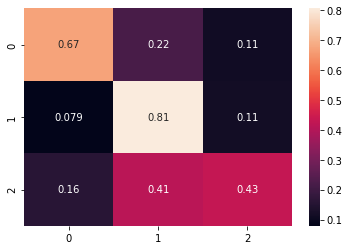

In [518]:
sns.heatmap(confusion_matrix(y_test, yhat_xgb, normalize='true'), annot=True, )

## 7.3 Random Forest 

In [519]:
clf_rf = RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42).fit(X_train, y_train)
yhat_rf = clf_rf.predict(X_test)

In [520]:
accuracy_score(y_test, yhat_rf)

0.6341463414634146

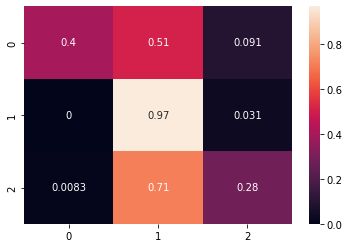

In [521]:
sns.heatmap(confusion_matrix(y_test, yhat_rf, normalize='true'), annot=True, );

## 7.4 SVM 

In [522]:
clf_svc = svm.SVC().fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)

In [523]:
accuracy_score(y_test, y_hat_svc)

0.5609756097560976

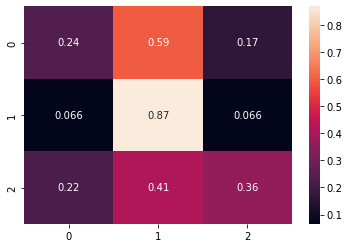

In [524]:
sns.heatmap(confusion_matrix(y_test, y_hat_svc, normalize='true'), annot=True);

## 7.5 SGD 

In [525]:
clf_sgd = SGDClassifier().fit(X_train, y_train)
y_hat_sgd = clf_sgd.predict(X_test)

In [526]:
accuracy_score(y_test, y_hat_sgd)

0.5182926829268293

<AxesSubplot:>

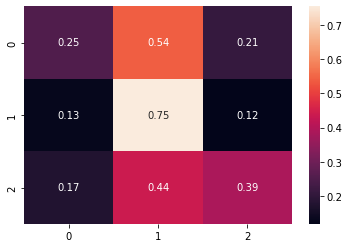

In [527]:
sns.heatmap(confusion_matrix(y_test, y_hat_sgd, normalize='true'), annot=True, )

## 7.6 MLP 

In [528]:
clf_mlp = MLPClassifier(max_iter=500).fit(X_train, y_train)
y_hat_mlp = clf_mlp.predict(X_test)

In [529]:
accuracy_score(y_test, y_hat_mlp)

0.5630081300813008

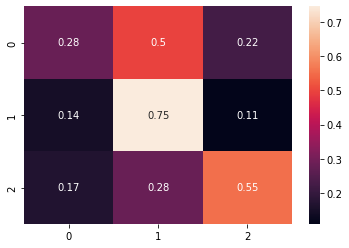

In [530]:
sns.heatmap(confusion_matrix(y_test, y_hat_mlp, normalize='true'), annot=True, );

# 7.0 Fine Tuning 